## 0. Intro
Use continuous geographic, hydrological, climate, and meteorological datasets as input to train neural network(NN) and random forest(RF) models, to determine the major environmentl drivers of algae growth in lakes.
Use Google Cloud Platform (GCP) to extract relative data from its [Earth Engine Dataset](https://developers.google.com/earth-engine/datasets) and run further NN models



[0.Intro](#scrollTo=dqS_PlyedNxv)

[1.Climate data preparation from Google Earth Engine](#scrollTo=XNAX5x7a5DT2)

[2.Download satellite imagery of the same dates/AOI](#scrollTo=qNBV8xLh5VMO)

[3.Images to statistics on GCP Virtual Machine](#scrollTo=0U-zxY4V3goK)

[4.Build machine learning models](#scrollTo=6kRAeA3s-Yka)

>[4.1Data Preparation](#scrollTo=OZSY4zgb-6n3)

>[4.2Model training](#scrollTo=qvW7rDxnAg32)

>[4.3Input feature importance](#scrollTo=s__0rzr0q7Tz)



## 1. Climate data preparation from Google Earth Engine

In [19]:
##connect to google earth engine
import ee
#service_account = '429406912917-compute@developer.gserviceaccount.com'
#credentials = ee.ServiceAccountCredentials(service_account, 'credentials.json')
#ee.Initialize(credentials)

from google.colab import auth
auth.authenticate_user()
ee.Authenticate()
ee.Initialize()

In [86]:
##prepare a mapping tool
import folium
def add_ee_layer(self, ee_image_object, vis_params, name):
  map_id_dict = ee.Image(ee_image_object).getMapId(vis_params)
  folium.raster_layers.TileLayer(
      tiles=map_id_dict['tile_fetcher'].url_format,
      attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
      name=name,
      overlay=True,
      control=True
  ).add_to(self)

folium.Map.add_ee_layer = add_ee_layer

In [21]:
### extract climate data from ECMWF ERA 5
##details of dataset: https://developers.google.com/earth-engine/datasets/catalog/ECMWF_ERA5_DAILY#description
## https://cds.climate.copernicus.eu/cdsapp#!/software/app-era5-explorer?tab=overview
sensor='ECMWF/ERA5/DAILY'
start_date,end_date='2020-06-01','2020-07-01'
aoi =ee.Geometry.Rectangle(-95.4, 48.88,-93.75, 49.77)
era5 = ee.ImageCollection(sensor) \
       .filterBounds(aoi)  \
       .filterDate(ee.Date(start_date), ee.Date(end_date))
era5_2mt = era5.select('mean_2m_air_temperature')
print('Number of images', era5_2mt.size().getInfo())

Number of images 30


In [22]:
##preview the average imagery
avgT=era5_2mt.mosaic().add(-273.15)  #kelvin to Celsius  c=k-273.15   #.clip(aoi)
##result = ee.Image.expression('(slope * aspect) / 255', {'slope': slope,'aspect': aspect})
print("Global temperature Jun 2020 monthly avg (C)")

## #show interactive map
## vis_params = {
##   'min': -30,
##   'max': 40,
##   'palette': ['blue', 'green', 'red']
## }
## center = aoi.centroid()
## map = folium.Map(location=[center.coordinates().get(1).getInfo(),center.coordinates().get(0).getInfo()], zoom_start=5)
## #map = folium.Map(location=[48.88,-95.4], zoom_start=10)
## # Add the image layer to the map and display it.
## map.add_ee_layer(avgT, vis_params, 'Avg Temp (c)')
## map.add_child(folium.LayerControl())
## display(map)

##display a raster imagery
from IPython.display import Image
Image(url =avgT.updateMask(avgT.gt(-10)).getThumbURL({'min':0, 'max': 40, 'dimensions': 512,
                'palette': ['blue', 'green', 'red']}))


Global temperature Jun 2020 monthly avg (C)


In [6]:
## export to a test imagery to Google Cloud Platform (GCP) buckets 
img=era5_2mt.first()
export_config = {
    'image': img,
    'region': aoi,
    'crs': 'EPSG:4326',
    'scale': 100000,    
    'fileFormat': 'GeoTIFF',
    'fileNamePrefix': 'ERA5_2mt',
    'bucket':   'AlgaeDrive',  
    'maxPixels':1e10,
    'description': 'ERA5 climate data download: ER5 mean_2m_air_temperature'
}
task=ee.batch.Export.image.toCloudStorage(**export_config)
#task=ee.batch.Export.image.toDrive(**export_config)
task.start()
import time
time.sleep(10)
print(task.status())

{'state': 'READY', 'description': 'ERA5 climate data download: ER5 mean_2m_air_temperature', 'creation_timestamp_ms': 1680028182464, 'update_timestamp_ms': 1680028182464, 'start_timestamp_ms': 0, 'task_type': 'EXPORT_IMAGE', 'id': 'UQFQZPCG5XE5SKJFP2QS4TKZ', 'name': 'projects/earthengine-legacy/operations/UQFQZPCG5XE5SKJFP2QS4TKZ'}


In [137]:
##download GEE dataset (ERA5, satellite imagery,DEM and ....) to bucket
def export_GEEdataset_to_GCPbucket(dataset,aoi=None, bucket_name='AlgaeDrive',crs_epsg=3174,scale=300,product_subset=None,product_name='OLCI'):
  img_list = dataset.toList(dataset.size())
  nImages = img_list.size().getInfo()

  ##iterate all the image to export to GCP bucket
  for i in range(nImages):
    img=ee.Image(img_list.get(i))
    if not (aoi is None): img=img.clip(aoi)

    id_str=''
    if product_name=='OLCI': id_str='PRODUCT_ID'
    elif product_name=='ERA5': id_str='id'
    else: return 

    product_id=img.get(id_str).getInfo()
    export_config = {
      'image': img.float(),
      #'region': aoi,
      'crs': f'EPSG:{crs_epsg}',
      'scale': scale,    #default in 300 pixels of OLCI
      'fileFormat': 'GeoTIFF',
      'fileNamePrefix': f'{product_name}/{product_id}{'' if (product_subset is None) else '_'+product_subset}',
      'bucket':   bucket_name,  
      'maxPixels':1e11,
      'description': f'GEE dataset download, product: {product_name}, sub dataset: {product_subset}'
    }
    task=ee.batch.Export.image.toCloudStorage(**export_config)
    task.start()

In [136]:
##download all the related products
dict_prdct={
'mean_2m_air_temperature': 'Daily mean 2m air temperature',
'total_precipitation': 'Daily total precipitation sums',
'dewpoint_2m_temperature': "Daily mean 2m dewpoint temperature",
'mean_sea_level_pressure':"Daily mean sea-level pressure",
'surface_pressure': "Daily mean surface pressure",
'u_component_of_wind_10m': "Daily mean 10m u-component of wind",
}
for prd in dict_prdct:
    era5_dat = era5.select(prd)
    print('Number of images', era5_dat.size().getInfo())
    export_GEEdataset_to_GCPbucket(era5_dat,aoi=aoi, bucket_name='AlgaeDrive',crs_epsg=32615,scale=1000,product_subset=prd,product_name='ERA5')

Number of images 30
Number of images 30
Number of images 30
Number of images 30
Number of images 30
Number of images 30


## 2. Download satellite imagery of the same dates/AOI

In [ ]:
crs_epsg=32615  #the epsg code for projection
start_date,end_date='2020-06-01','2020-07-01'
aoi =ee.Geometry.Rectangle(-95.4, 48.88,-93.75, 49.77)
sensor='COPERNICUS/S3/OLCI'
olci_imgs=ee.ImageCollection(sensor) \
       .filterBounds(aoi)  \
       .filterDate(ee.Date('2022-09-01'), ee.Date('2022-09-03'))
export_GEEdataset_to_GCPbucket(olci_imgs,aoi=aoi, bucket_name='AlgaeDrive',crs_epsg=32615,scale=300,product_subset=None,product_name='OLCI')

## 3. Images to statistics on GCP Virtual Machine

In [ ]:
## download other similar satellite products

###...

## download geographic dataset e.g.,  DEM
 
### ...

## download the output variable (chlorophyll-concentration) from EOLakewatch
## https://hpfx.collab.science.gc.ca/~sntl123/GeoTIFFs/LoW/  (only need 2016-present geotiff files)

## GCP virtual machine extract input and output variable as a single dataset.
## using geospatial open source software `gpt`:  https://step.esa.int/main/download/snap-download/

## 4. build machine learning models 

### 4.1  Data Preparation

In [10]:
##  some auxilary functions 
import pandas as pd
import numpy as np
def sci_notation(number, sig_fig=2):
    """
    convert scientific numbers to "###x10^###" type
    """
    ret_string = "{0:.{1:d}e}".format(number, sig_fig)
    a,b = ret_string.split("e")
    b = int(b) #removed leading "+" and strips leading zeros too.
    return a + 'x10$^{' + str(b)+'}$'

##metrics
EPSILON = 1e-10
def _error(actual: np.ndarray, predicted: np.ndarray):
    """ Simple error """
    return predicted - actual
def _percentage_error(actual: np.ndarray, predicted: np.ndarray, bZero=False):
    """
    Percentage error
    Note: result is NOT multiplied by 100
    """
    if not bZero:  
        return _error(actual, predicted) / (actual + EPSILON)
    else: ##to avoid the extreme high percentage at values close to zero       
        Tmin=np.max([np.nanmin(actual)+1e-4*np.ptp(actual), np.nanpercentile(actual,2)])  # <2% or 0.1%+min, which ever is larger
        val=_error(actual, predicted) / (actual + EPSILON)
        val[actual<Tmin]=np.nan  #set the values lower than min threshold as invalid
        return val
def stats_mse(actual: np.ndarray, predicted: np.ndarray):
    """ Mean Squared Error """
    return np.mean(np.square(_error(actual, predicted)))

def stats_rmse(actual: np.ndarray, predicted: np.ndarray):
    """ Root Mean Squared Error """
    return np.sqrt(stats_mse(actual, predicted))
def stats_bias(actual: np.ndarray, predicted: np.ndarray):
    return np.sum(_error(actual, predicted)) / len(actual)
def stats_rsquare(actual: np.ndarray, predicted: np.ndarray):
    r=np.corrcoef(predicted, actual)[0,1]
    return r**2
def stats_mdape(actual: np.ndarray, predicted: np.ndarray):
    """
    Median Absolute Percentage Error
    Note: result is NOT multiplied by 100
    """
    return np.median(np.abs(_percentage_error(actual, predicted)))

In [3]:
def WaterIndex(Rrs,Bands=[681, 709, 753]):
    """
    cacluate line height water index
    """
    if np.any(np.isnan(Rrs)):  #data validation
        return np.nan
    else:
        idx=Rrs[1]-Rrs[0]- (Bands[1]-Bands[0])/(Bands[2]-Bands[0])*(Rrs[2]-Rrs[0])
    return idx
def plot_performance(y_test,y_pred,x_range=[2,7.5], model_name='', model_str=''):
    import matplotlib.pyplot as plt
    from sklearn.metrics import mean_squared_error
    #mse = mean_squared_error(y_test, y_pred)
    #rmse = mse**(0.5)
    #print("MSE: %.2f" % mse)
    #print("RMSE: %.2f" % rmse)
    x = np.linspace(x_range[0],x_range[1],100)
    plt.figure()
    stats={'rmse':stats_rmse(y_test,y_pred),'bias':stats_bias(y_test,y_pred),'mdape':stats_mdape(y_test,y_pred),'rsquare':stats_rsquare(y_test,y_pred)}
    print(stats)
    plt.title(model_name,fontweight='bold',fontsize=12,color= 'k')
    plt.plot(y_test,y_pred,'b.')
    plt.plot(x,x,'r')
    plt.text(0.7,0.05, " R$^2$={:.3f} \n RMSE={:.3f} \n BIAS={:.3f} \n MAPE={:.3f}".format
             (stats['rsquare'],stats['rmse'], stats['bias'],stats['mdape']),
             fontsize=12,weight='bold',transform=plt.gca().transAxes)
    plt.text(0.05, 0.9,f'NN: {model_str}',fontsize=12,weight='bold',transform=plt.gca().transAxes)
    #plt.xlabel('observed Chl [\u03BCg/L]'),plt.ylabel('predicted Chl [\u03BCg/L]')
    plt.xlabel('observed density logged [cells/mL]'),plt.ylabel('predicted density logged [cells/mL]')
    plt.grid()
    plt.plot(x, x,'r')

def lightGBM(X_train, y_train,X_test, y_test,bPlot=True,bRegression=False , N=5,sample_weights=None):
    ##implementation 3: LightGBM
    import lightgbm as lgb
    import random
    #import joblib
    #import numpy as np
    #from pathlib import Path
    #import typer
    # defining parameters 
    params = {
        'task': 'train', 
        'boosting': 'gbdt',
        'objective': 'regression' if bRegression else 'multiclass' ,
        'num_class': 1 if bRegression else 5,
        'num_leaves': 10,  #31,  #depth
        'learning_rate': 0.05,
        'feature_fraction': 0.9,
        'bagging_fraction': 0.8,
        #'bagging_freq': 5,
        'metric': 'rmse' if bRegression else 'multi_logloss' ,  #{'l2','l1'},
        'verbose': -1
    }
    # loading data
    if sample_weights is None:lgb_train = lgb.Dataset(X_train, y_train)
    else: lgb_train = lgb.Dataset(X_train, y_train, weight=sample_weights)
    lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)
    
    model_list=list()
    for idx in range(N):   
        # fitting the model
        params['seed']=random.randint(1, 1000)  #use a random number in 1-1000 as seed
        model = lgb.train(params,train_set=lgb_train,valid_sets=lgb_eval,early_stopping_rounds=30,verbose_eval=False)
        model_list.append(model)
    
    # Make predictions for the test data using each model
    predictions = []
    for model in model_list:
        prediction = model.predict(X_test)
        predictions.append(prediction)
    
    # Average the predicted probabilities across all models
    y_pred_gbm = np.mean(predictions, axis=0)
    ### prediction
    ##y_pred_gbm = model.predict(X_test)       
        
    from sklearn.metrics import mean_squared_error
    from sklearn.metrics import confusion_matrix
    if  not bRegression:
        y_pred_gbm = np.argmax(y_pred_gbm, axis=1)
        rmse = mean_squared_error(y_test, y_pred_gbm)**(0.5)
        print('=== classification Accuracy:', np.sum(y_pred_gbm == y_test) / len(y_test),'; RMSE:',rmse)
        #print('classification Accuracy:', np.sum(y_pred_gbm == y_test) / len(y_test))
        cm = confusion_matrix(y_test, y_pred_gbm)
        print("confusion matrix: \n",cm)
    else:
        # accuracy check
        if bPlot: plot_performance(y_test,y_pred_gbm,model_name='lightGBM',model_str=params['num_leaves'])
        
        y_test = np.digitize(y_test, bins=np.log10([20000 , 100000, 1000000, 10000000]))
        y_pred_gbm = np.digitize(y_pred_gbm, bins=np.log10([20000 , 100000, 1000000, 10000000]))
        rmse = mean_squared_error(y_test, y_pred_gbm)**(0.5)
        print('=== classification Accuracy:', np.sum(y_pred_gbm == y_test) / len(y_test),'; RMSE:',rmse)
        cm = confusion_matrix(y_test, y_pred_gbm)
        print("confusion matrix: \n",cm)
    
    # Get the feature importances
    importance = model.feature_importance()
    # Get the feature names
    feature_names = X_train.columns
    # Create a dictionary of feature names and importance scores
    feature_importance_dict = dict(zip(feature_names, importance))
    ## Print the feature importances in descending order
    print(sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True))

    return model

def RandomForeset(X_train, y_train,X_test,y_test,bPlot=True,bRegression=False ,N=1,sample_weights=None):
    #Import Random Forest Model
    from sklearn.ensemble import RandomForestRegressor,RandomForestClassifier
    
    ###normalize the samples weight to make sum as 1
    #if not (sample_weights is None):
    #  from sklearn.preprocessing import normalize
    #  sample_weights = np.sqqueze(  normalize([np.array(sample_weights)], norm='l1'))

    model_list=list()
    for idx in range(N):
        #from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
        if bRegression:  
          rfr = RandomForestRegressor(n_estimators=100)
        else:  
          rfr = RandomForestClassifier(n_estimators=100) #, random_state=42; if set this random_state , then model give same output?
        #print(rfr)
        
        '''
        RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                              max_depth=None, max_features='auto', max_leaf_nodes=None,
                              max_samples=None, min_impurity_decrease=0.0,
                              min_samples_leaf=1,
                              min_samples_split=2, min_weight_fraction_leaf=0.0,
                              n_estimators=100, n_jobs=None, oob_score=False,
                              random_state=None, verbose=0, warm_start=False) 
        '''
        if sample_weights is None:rfr.fit(X_train, y_train)
        else: rfr.fit(X_train, y_train, sample_weight=sample_weights)
        #score = rfr.score(X_train, y_train)
        #print("training dataset R-squared:", score) 
        model_list.append(rfr)

    # Make predictions for the test data using each model
    predictions = []
    for model in model_list:
        if bRegression: prediction = model.predict(X_test)
        else: prediction = model.predict_proba(X_test)
        predictions.append(prediction)
    
    # Average the predicted probabilities across all models
    ypred_rf = np.mean(predictions, axis=0)
    
    # Get the predicted class for each sample
    if not bRegression: ypred_rf = np.argmax(ypred_rf, axis=1)

    from sklearn.metrics import mean_squared_error
    from sklearn.metrics import confusion_matrix
    if bRegression: 
        if bPlot: plot_performance(y_test,ypred_rf,model_name='RandomForeset',model_str='')

        y_test = np.digitize(y_test, bins=np.log10([20000 , 100000, 1000000, 10000000]))
        ypred_rf = np.digitize(ypred_rf, bins=np.log10([20000 , 100000, 1000000, 10000000]))
        rmse = mean_squared_error(y_test, ypred_rf)**(0.5)
        print('=== classification Accuracy:', np.sum(ypred_rf == y_test) / len(y_test),'; RMSE:',rmse)
        cm = confusion_matrix(y_test, ypred_rf)
        print("confusion matrix: \n",cm)
        
    else:
        rmse = mean_squared_error(y_test, ypred_rf)**(0.5)
        #region_rmse=lambda y_test, y_pred: 
        print('=== classification Accuracy:', np.sum(ypred_rf == y_test) / len(y_test),'; RMSE:',rmse)
        cm = confusion_matrix(y_test, ypred_rf)
        print("confusion matrix: \n",cm)
        
    return rfr    

def TensorFlow(X_train, y_train,X_test,y_test,bPlot=True,Ntraining=1,nodes=[64,64],drop_rate=0.3,reg_factor=1e-8,batch_size=128,epochs=64):
    ## Impelentation : training with ANN via tensorflow
    ## TRAINING WITH tensorflow, adapted from : https://github.com/chqzeng/MODISNN/blob/main/MODISNN_TF/MODISNN_TF_training.py
    import tensorflow as tf
    ## ---- NN training  : [X_train, X_test, y_train, y_test] ---
    # Create a `Sequential` model and add Dense layers 
    model_list=list()
      #hidden layer nodes
    #repeated training times
    regularizer=tf.keras.regularizers.L1(reg_factor)  
    init=tf.keras.initializers.RandomUniform(minval=-0.05, maxval=0.05, seed=None)
    model = tf.keras.models.Sequential()
    model.add(tf.keras.Input(shape=(X_train.shape[1],), name="input"))
    for idx in range(len(nodes)):
        #model.add(tf.keras.layers.Dense(nodes[idx], activation='relu', name="dense{}".format(idx)))
        model.add(tf.keras.layers.Dense(nodes[idx],kernel_regularizer=regularizer,kernel_initializer = init, activation='relu', name="dense{}".format(idx))) 
        ##activation='sigmoid'  'relu' 'tanh'  activation=tf.keras.layers.LeakyReLU(alpha=0.01)  tf.keras.layers.PReLU() 'elu'; in general SELU > ELU > leaky ReLU (and its variants) > ReLU > tanh > logistic
        model.add(tf.keras.layers.Dropout(drop_rate))
    Nout=1 if len(y_train.shape)==1 else y_train.shape[1]  #if output 1-dimension then, output dimension=1; if 2-d output, then output dimension=shape[1]
    model.add(tf.keras.layers.Dense(Nout,  name="output",activation='relu'))
    opt = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False)
    model.compile(loss='mse', optimizer=opt,metrics=['accuracy'])  # metrics=['accuracy'])  #optimizer='adam'
    Wreset = model.get_weights()     ##store the param for reset
    #print('=== repeat training (100%): ', end="")
    for idx in range(0,Ntraining):
        history = model.fit(X_train,y_train,batch_size=batch_size,epochs=epochs,verbose=False) #,validation_split = 0.3)
        model_list.append({"idx":idx,"weights":model.get_weights(),"history":history} ) #store the model history
        #model.save('__test__.model')  #save the full keras model;  load later as: model=keras.models.load_model("__test__.model")
        print(model.get_weights()[0])
        ##show stats
        Y_pred=np.squeeze(model.predict(X_test,verbose=False))
        Y_pred[Y_pred>8]=8
        Y_pred[Y_pred<0]=0
        ## calculate stats
        stats={'rmse':stats_rmse(y_test,Y_pred),'bias':stats_bias(y_test,Y_pred),'mdape':stats_mdape(y_test,Y_pred),'rsquare':stats_rsquare(y_test,Y_pred)}  #metrics=('rmse', 'bias', 'mdape', 'rsquare'))
        print(stats)
        model.set_weights(Wreset)
    
    ##  ANN prediction
    Y_pred_list=np.ndarray([Ntraining,y_test.shape[0]], dtype=float)
    for idx in range(0,Ntraining):
        model.set_weights(model_list[idx]['weights'])
        Y_pred_list[idx,:]=np.squeeze(model.predict(X_test,verbose=False))
    ## using median prediction of many training attemps (similar to random forest) 
    Y_pred=np.median(Y_pred_list,axis=0)  
    ##force range
    if bPlot: plot_performance(y_test,Y_pred,model_name='Tensorflow',model_str=str(nodes))
##--------------------

In [ ]:
import os
##load existing data; initial datasets
work_dir='./'
sample_data = pd.read_csv(os.path.join(work_dir,"training.csv"))  #pd.read_csv('../Sentinel3_TOA_training.csv')

## load climate data
#data_HRRR = pd.read_csv(os.path.join(work_dir, 'DEM_and_HRRR/HRRR.csv'))
#data_DEM = pd.read_csv(os.path.join(work_dir, 'DEM_and_HRRR/DEM.csv'))
#train_labels = pd.read_csv(os.path.join(work_dir, 'Code/train_labels.csv'))
#metadata = pd.read_csv(os.path.join(work_dir, 'Code/metadata.csv'))

inputFeatures=['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'NDVI', 'NDCI', 'B8AB4', 'B3B2','dem','test2',
               'mean_2m_air_temperature',
'total_precipitation    ',
'dewpoint_2m_temperature',
'mean_sea_level_pressure',
'surface_pressure       ',
'u_component_of_wind_10m',]
X = sample_data[inputFeatures]  # Features
#X = results[['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7','NDVI', 'NDCI', 'B8AB4', 'B3B2','test1','test2']]  # Features
y=sample_data['chl_a']    # the output variable is the chlorophyll a concentration from our EOLakeWatch

### 4.2 Model training

--------------------light GBM : S2 : Classfication------------------


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


{'rmse': 1.1179066631995502, 'bias': 0.0023202206491265715, 'mdape': 0.13882803075485073, 'rsquare': 0.27615997265395864}
=== classification Accuracy: 0.3412698412698413 ; RMSE: 1.0593499054713802
confusion matrix: 
 [[109 219  75   2   0]
 [ 20 133  71   1   0]
 [  9 134 165   4   0]
 [  5  74 204  23   0]
 [  0   3   9   0   0]]
[('B4B3', 107), ('B3B2', 104), ('NDCI', 88), ('MCI', 87), ('B1', 74), ('B8AB4', 72), ('B2', 62), ('NDVI', 57), ('B8A', 38), ('B5', 36), ('B4', 34), ('B3', 32), ('B6', 28), ('B7', 19), ('B8', 19), ('B8B4', 16)]
--------------------Random Forest : S2 : Classfication------------------
{'rmse': 1.0666937214949745, 'bias': -0.04255510666878046, 'mdape': 0.12536594232424797, 'rsquare': 0.3388379151282048}
=== classification Accuracy: 0.43174603174603177 ; RMSE: 1.0157490003667402
confusion matrix: 
 [[184 153  64   4   0]
 [ 35 118  71   1   0]
 [ 19 111 170  12   0]
 [  9  60 165  72   0]
 [  0   3   8   1   0]]


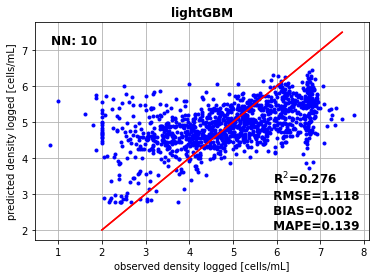

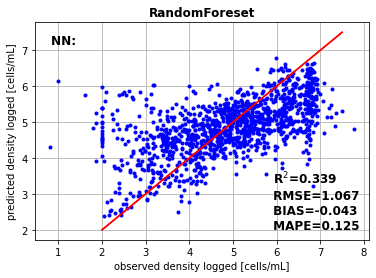

In [11]:
## ---------------- training  ----------------
# Import train_test_split function
from sklearn.model_selection import train_test_split
## Split dataset into training set and test set;  reokaced by the block below, since the train_test_split does not return flag to further split weight column
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3) # 70% training and 30% test

sensor_model='S2'
bCategory=True

T=700 ## split the random numbers in range [0,1000)  as training and test
flt_training = np.random.randint(1000, size=sample_data.shape[0]) < T
#sum(flt_training)/(1.0*sample_data.shape[0]), sum(~flt_training)/(1.0*sample_data.shape[0]), sample_data.shape
sample_weights=sample_data.loc[flt_training,'sample_weight']
X_train, X_test, y_train, y_test = X.loc[flt_training,:],X.loc[~flt_training,:], y[flt_training],y[~flt_training]

print(f'--------------------light GBM : {sensor_model} : {"Classfication" if bCategory else "Regression"}------------------')
gbm=lightGBM(X_train, y_train,X_test, y_test,bPlot=True,sample_weights=sample_weights,bRegression=not bCategory,N=5)  #N=5 means train the model 5 times & average the prediction

print(f'--------------------Random Forest : {sensor_model} : {"Classfication" if bCategory else "Regression"}------------------')
rfr=RandomForeset(X_train, y_train,X_test, y_test,bPlot=True,sample_weights=sample_weights,bRegression=not bCategory,N=5)

#print(f'--------------------tensorflow  : {sensor_model} : {"Classfication" if bCategory else "Regression"}------------------')
#TensorFlow(X_train, y_train,X_test,y_test,Ntraining=3,bPlot=True)

### 4.3 Input feature importance

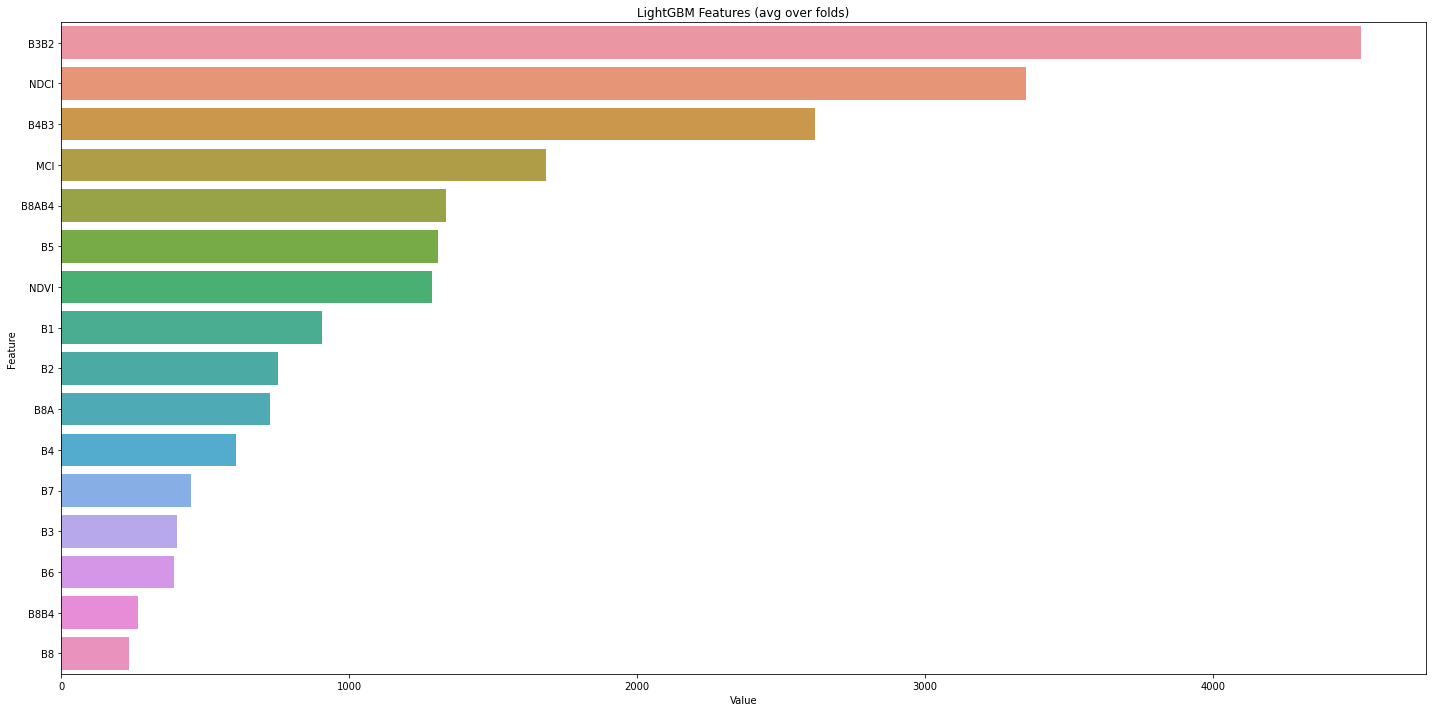

In [17]:
import matplotlib.pyplot as plt
# method 1: Get feature importances from the lightGBM default method
feature_importances = gbm.feature_importance(importance_type='gain')

#x_axis=range(len(feature_importances))
#plt.bar(x_axis, feature_importances)
#plt.xticks(x_axis, X.columns)
#plt.show()

import seaborn as sns
feature_imp = pd.DataFrame(sorted(zip(gbm.feature_importance(importance_type='gain'),X.columns)), columns=['Value','Feature'])
plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.show()

In [1]:
## method2: Get feature importance from SHAP python package: https://github.com/slundberg/shap
## some explanation: https://christophm.github.io/interpretable-ml-book/shap.html#shap-feature-importance 

!pip install git+https://github.com/slundberg/shap.git

import shap
shap.initjs()

model=TensorFlow(X_train, y_train,X_test,y_test)
explainer = shap.DeepExplainer(model, X_test.to_numpy()[1::5]) 
shap_values = explainer.shap_values(X_test.to_numpy()[::100])
feature_shaps=np.mean(abs(shap_values),axis=0)
feature_imp = pd.DataFrame(sorted(zip(feature_shaps,X.columns)), columns=['Value','Feature'])
plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('mean(|SHAP value|) in model output magnitude')
plt.tight_layout()
plt.show()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/slundberg/shap.git to /tmp/pip-req-build-8u5tsee3
  Running command git clone --filter=blob:none --quiet https://github.com/slundberg/shap.git /tmp/pip-req-build-8u5tsee3
  Resolved https://github.com/slundberg/shap.git to commit 45b85c1837283fdaeed7440ec6365a886af4a333
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for shap: filename=shap-0.41.0-cp39-cp39-linux_x86_64.whl size=2599381 sha256=955179ffa3e1a8829544f023e83a38503da10eb020939c726ac9d4658f0bdc79
  Stored in directory: /tmp/pip-ephem-wheel-cache-m2wf298a/wheels/2c/ae/7b/4faf6ded0883c234766ea38da98f86ccc33dbbbdd2dfcfd740
Successfully built shap
